 All required import statement

In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
# import tensorflow as tf
import os
import gc

from sklearn import set_config
from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

sns.set_theme(style='white', palette='viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
set_config(transform_output='pandas')
pd.options.mode.chained_assignment = None
seed = 42
tss = TimeSeriesSplit(9)
kf = KFold(n_splits=10)
os.environ['PYTHONHASHSEED'] = '42'

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Prepare the function to read the data

In [2]:
dtypes = {
    'stock_id': np.uint8,
    'date_id': np.uint16,
    'seconds_in_bucket': np.uint16,
    'imbalance_buy_sell_flag': np.int8,
    'time_id': np.uint16,
}


def imbalance_calculator(x):

    x_copy = x.copy()

    x_copy['imb_s1'] = x.eval('(bid_size - ask_size) / (bid_size + ask_size)')
    x_copy['imb_s2'] = x.eval(
        '(imbalance_size - matched_size) / (matched_size + imbalance_size)')

    prices = ['reference_price', 'far_price',
              'near_price', 'ask_price', 'bid_price', 'wap']

    for i, a in enumerate(prices):
        for j, b in enumerate(prices):
            if i > j:
                x_copy[f'{a}_{b}_imb'] = x.eval(f'({a} - {b}) / ({a} + {b})')

    for i, a in enumerate(prices):
        for j, b in enumerate(prices):
            for k, c in enumerate(prices):
                if i > j and j > k:
                    max_ = x[[a, b, c]].max(axis=1)
                    min_ = x[[a, b, c]].min(axis=1)
                    mid_ = x[[a, b, c]].sum(axis=1)-min_-max_

                    x_copy[f'{a}_{b}_{c}_imb2'] = (max_-mid_)/(mid_-min_)

    return x_copy


def read_data(data_path: str):
    """Read the data from the train and test csv files, split them into the x (features) and y(target)

    Args:
        data_path (str): absolute save path for the train and test data set 

    Returns:
        X (dataframe): Independent features for training
        y (dataframe): dependent features for training  
        X_test (dataframe): Independent features for testing
    """
    # Load data from the save path
    train = pd.read_csv(f'{data_path}/train.csv',
                        dtype=dtypes)
    train.drop(['row_id', 'time_id'], axis=1, inplace=True)
    train = imbalance_calculator(train)
    test = pd.read_csv(f'{data_path}/test.csv',
                       dtype=dtypes).drop(['row_id', 'time_id'], axis=1)

    # Check the data set
    train.info()
    print(train.head())
    print(train.tail())
    gc.collect()

    # split data into X and y
    X = train[~train.target.isna()]
    y = X.pop('target')

    # Test data dont have target column
    X_test = test[~train.target.isna()]

    X.info()
    print(X.head())
    return X, y, X_test

 add_derivatives("D:/OneDrive/NEU/CS6140/optiver-trading-at-the-close")

 This section will prepare the cross_validation function
 cv = time series split of 10

In [3]:
def cross_validation(estimator, save_path, X, y, X_test, cv=kf, label=''):
    """cross validation function

    Args:
        estimator (model): chosen model 
        save_path (str) : target directory to save the model
        X (dataframe): Independent features for training
        y (dataframe): dependent features for training  
        X_test (dataframe): Independent features for testing
        cv (split, optional): split for the cross validation. Defaults to tss.
        label (str, optional): special label. Defaults to ''.

    Returns:
        _type_: _description_
    """
    # Build the save path if not exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X)))
    # train_predictions = np.zeros((len(sample)))
    train_scores, val_scores = [], []
    best_model = None
    best_model_train_score = 0
    best_val_score = 0
    best_fold = 0

    # training model, predicting prognosis probability, and evaluating metrics
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):

        model = clone(estimator)

        # define train set
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]

        # define validation set
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]

        # train model
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

        # Save the model
        joblib.dump(model, f'./{save_path}/{label}_{fold}.model')

        # make predictions
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)

        val_predictions[val_idx] += val_preds

        # evaluate model for a fold
        train_score = mean_absolute_error(y_train, train_preds)
        val_score = mean_absolute_error(y_val, val_preds)

        # Update best model
        if best_val_score == 0 or val_score < best_val_score:
            best_val_score = val_score
            best_model_train_score = train_score
            best_model = model
            best_fold = fold

        # append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)

    # This line print the average
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    for fold in range(len(val_scores)):
        print(
            f'fold:{fold}, Val Score: {val_scores[fold]}, Train Score: {train_scores[fold]}')
    # Print best model score
    print(
        f'Best validation score: {best_val_score}, associated train score: {best_model_train_score}')
    joblib.dump(best_model, f'./{save_path}/best_model.model')

    return val_scores, val_predictions

 This will set the Optuna objective function
 Set the objective function for Optuna study and running trials

In [4]:
def objective(trial, X, y):
    max_depth = trial.suggest_int("max_depth", 4, 12)
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": max_depth,
        "num_leaves": trial.suggest_int("num_leaves", 2**(max_depth-1), 2**(max_depth), step=2**(max_depth-1)//8),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 32, 256),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "subsample": trial.suggest_float("subsample", 0.5, 1)
    }
    cv = kf
    cv_scores = np.empty(10)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # define train set
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]

        # define validation set
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]

        model = LGBMRegressor(random_state=seed, objective='mse',
                              device_type='gpu', early_stopping_rounds=100, **param_grid)
        # train model
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],  callbacks=[
                  LightGBMPruningCallback(trial, 'l2')])
        val_preds = model.predict(X_val)

        # evaluate model for a fold
        val_score = mean_absolute_error(y_val, val_preds)
        cv_scores[fold] = val_score
    return np.mean(cv_scores)

 Call the required function and run the model

In [5]:
X, y, X_test = read_data(
    "D:/OneDrive/NEU/CS6140/optiver-trading-at-the-close")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 52 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   stock_id                                   uint8  
 1   date_id                                    uint16 
 2   seconds_in_bucket                          uint16 
 3   imbalance_size                             float64
 4   imbalance_buy_sell_flag                    int8   
 5   reference_price                            float64
 6   matched_size                               float64
 7   far_price                                  float64
 8   near_price                                 float64
 9   bid_price                                  float64
 10  bid_size                                   float64
 11  ask_price                                  float64
 12  ask_size                                   float64
 13  wap                                       

<ipython-input-2-ace71c937563>:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test = test[~train.target.isna()]


 Run the optuna function

In [6]:
study = optuna.create_study(direction='minimize', study_name='LGBM Regressor')
def func(trial): return objective(trial, X, y)


study.optimize(func, n_trials=20)

[I 2023-12-09 10:48:38,147] A new study created in memory with name: LGBM Regressor


[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3879
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[150]	valid_0's l2: 92.0629


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[148]	valid_0's l2: 107.498


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[150]	valid_0's l2: 98.6829


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[150]	valid_0's l2: 97.1226
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_g

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[149]	valid_0's l2: 72.5555


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[150]	valid_0's l2: 84.6562


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[150]	valid_0's l2: 88.9325


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[150]	valid_0's l2: 79.6522


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[146]	valid_0's l2: 77.4361


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307


[I 2023-12-09 10:56:33,121] Trial 0 finished with value: 6.270259367045999 and parameters: {'max_depth': 9, 'n_estimators': 150, 'learning_rate': 0.06772311913826479, 'num_leaves': 480, 'min_data_in_leaf': 4100, 'max_bin': 78, 'min_gain_to_split': 10.128856386646307, 'subsample': 0.9138045192239712}. Best is trial 0 with value: 6.270259367045999.


[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.238281655018057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.238281655018057
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.238281655018057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.238281655018057
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[96]	valid_0's l2: 92.0201


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.238281655018057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.238281655018057
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.238281655018057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.238281655018057
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.238281655018057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.238281655018057
[LightGBM] [Info] This is the

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[89]	valid_0's l2: 107.439
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.238281655018057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.238281655018057
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.238281655018057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.238281655018057
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is se

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[67]	valid_0's l2: 98.7178
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.238281655018057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.238281655018057


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.238281655018057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.238281655018057
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.238281655018057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.238281655018057
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 4714103, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[122]	valid_0's l2: 97.0439
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.238281655018057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.238281655018057
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.238281655018057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.238281655018057
[Light

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[146]	valid_0's l2: 84.5723
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.238281655018057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.238281655018057
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.238281655018057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.238281655018057
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[67]	valid_0's l2: 79.6165


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.238281655018057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.238281655018057
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.238281655018057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.238281655018057
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.238281655018057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.238281655018057
[LightGBM] [Info] This is the

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[92]	valid_0's l2: 77.4444


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=2.238281655018057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.238281655018057


[I 2023-12-09 11:04:53,251] Trial 1 finished with value: 6.271970905259551 and parameters: {'max_depth': 9, 'n_estimators': 450, 'learning_rate': 0.16492219302464303, 'num_leaves': 288, 'min_data_in_leaf': 2900, 'max_bin': 44, 'min_gain_to_split': 2.238281655018057, 'subsample': 0.674400665464589}. Best is trial 0 with value: 6.270259367045999.


[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11006
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 92.2376


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(


Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 107.668
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored.

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 98.8127


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 97.2689


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(


Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 72.6587
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored.

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 84.7813


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[299]	valid_0's l2: 89.081


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[299]	valid_0's l2: 79.8324


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[299]	valid_0's l2: 77.594


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=13.769483796950768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.769483796950768


[I 2023-12-09 11:22:52,196] Trial 2 finished with value: 6.273566634873149 and parameters: {'max_depth': 11, 'n_estimators': 300, 'learning_rate': 0.02490564633839197, 'num_leaves': 1536, 'min_data_in_leaf': 6700, 'max_bin': 224, 'min_gain_to_split': 13.769483796950768, 'subsample': 0.6907087994559471}. Best is trial 0 with value: 6.270259367045999.


[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 10958
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel wit

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 92.1119
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Curr

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[97]	valid_0's l2: 107.609


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Info] This is the

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


Did not meet early stopping. Best iteration is:
[93]	valid_0's l2: 98.7583
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Curre

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 97.198


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Info] This is the

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[98]	valid_0's l2: 72.6174
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 10957
[LightGBM] [Info] Number of data points in the train set: 4714103, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel wit

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 84.683
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_t

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 88.9474
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 10958
[LightGBM] [Info] Number of data points in the train set: 4714103, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel wit

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 79.7859
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 10958
[LightGBM] [Info] Number of data points in the train set: 4714103, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel wit

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[78]	valid_0's l2: 77.5604


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=4.436511622054979, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.436511622054979


[I 2023-12-09 11:26:34,094] Trial 3 finished with value: 6.275905072295396 and parameters: {'max_depth': 6, 'n_estimators': 100, 'learning_rate': 0.21564655573175145, 'num_leaves': 56, 'min_data_in_leaf': 2000, 'max_bin': 223, 'min_gain_to_split': 4.436511622054979, 'subsample': 0.5407893228765711}. Best is trial 0 with value: 6.270259367045999.


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12202
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 25

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 340 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 341 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 349 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 352 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 356 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 357 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 359 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 365 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 368 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 370 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 374 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 375 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 376 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 377 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 378 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 379 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 395 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 396 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 398 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[400]	valid_0's l2: 92.1335


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 399 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Info] This is the GPU t

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 340 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 341 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 344 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 349 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 352 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 356 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 357 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 359 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 365 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 368 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 370 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 374 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 375 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 376 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 377 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 378 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 379 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 395 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 396 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 398 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 399 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[396]	valid_0's l2: 107.511
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_spl

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 340 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 341 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 344 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 349 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 352 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 356 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 357 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 359 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 365 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 368 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 370 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 374 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 375 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 376 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 377 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 378 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 379 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 395 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 396 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 398 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 399 is already reported.
  warnings.warn(


Did not meet early stopping. Best iteration is:
[391]	valid_0's l2: 98.7618
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current va

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 340 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 341 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 344 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 349 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 352 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 356 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 359 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 365 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 368 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 370 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 374 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 375 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 376 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 377 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 378 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 379 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 395 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 396 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 398 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 399 is already reported.
  warnings.warn(


Did not meet early stopping. Best iteration is:
[395]	valid_0's l2: 97.2096
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current va

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 340 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 341 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 344 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 349 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 352 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 356 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 357 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 359 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 365 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 368 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 370 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 374 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 375 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 376 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 377 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 378 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 379 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 395 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 396 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[393]	valid_0's l2: 72.6249


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 398 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 399 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Info] This is the GPU t

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 340 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 341 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 344 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 349 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 352 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 356 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 357 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 359 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 365 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 368 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 370 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 374 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 375 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 376 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 377 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 378 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 379 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 398 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[400]	valid_0's l2: 84.5497


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 399 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Info] This is the GPU t

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already re

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 340 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 341 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 344 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 352 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 356 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 357 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 359 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 365 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 368 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 370 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 374 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 375 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 376 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 377 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 378 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 379 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 395 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 396 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 398 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 399 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[399]	valid_0's l2: 89.0284
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_spl

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 340 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 341 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 344 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 349 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 352 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 356 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 357 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 359 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 365 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 368 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 370 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 374 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 375 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 376 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 377 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 378 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 379 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 395 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 396 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 398 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 399 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[395]	valid_0's l2: 79.818
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_spli

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is alrea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 344 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 349 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 350 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 351 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 352 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 353 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 354 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 355 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 356 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 357 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 358 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 359 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 360 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 361 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 362 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 363 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 364 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 365 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 366 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 367 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 368 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 369 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 370 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 371 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 372 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 373 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 374 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 375 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 376 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 377 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 378 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 379 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 380 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 381 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 382 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 383 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 384 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 385 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 386 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 387 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 388 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 389 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 390 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 391 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 392 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 393 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 394 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 395 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 396 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 397 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 398 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 399 is already reported.
  warnings.warn(


Did not meet early stopping. Best iteration is:
[320]	valid_0's l2: 77.524
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=4.060920011404557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.060920011404557


[I 2023-12-09 11:39:38,046] Trial 4 finished with value: 6.274162834433167 and parameters: {'max_depth': 7, 'n_estimators': 400, 'learning_rate': 0.03200135356388468, 'num_leaves': 64, 'min_data_in_leaf': 300, 'max_bin': 249, 'min_gain_to_split': 4.060920011404557, 'subsample': 0.5201035542734405}. Best is trial 0 with value: 6.270259367045999.


[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=13.877350958429565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.877350958429565
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=13.877350958429565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.877350958429565
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5250
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel 

[I 2023-12-09 11:39:46,744] Trial 5 pruned. Trial was pruned at iteration 22.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5641
[LightGBM] [Info] Number of data points in the train set: 4714102, number of us

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[129]	valid_0's l2: 107.533


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Info] This is the

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[146]	valid_0's l2: 98.7015


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Info] This is the

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[238]	valid_0's l2: 97.0932


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Info] This is the

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[163]	valid_0's l2: 72.5318


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Info] This is the

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 311 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 312 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 313 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 314 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 315 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 316 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 317 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 318 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 319 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 320 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 321 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 322 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 323 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 324 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 325 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 326 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 327 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 328 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 329 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 330 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 331 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 332 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 333 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 334 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 335 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 336 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 337 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 338 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 339 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 340 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 341 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 342 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 343 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 344 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 345 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 346 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 347 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 348 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 349 is already reported.
  warnings.warn(


Did not meet early stopping. Best iteration is:
[283]	valid_0's l2: 84.5898
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Curr

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 205 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 206 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 207 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 208 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 209 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 210 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 211 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 212 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 213 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 214 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 215 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 216 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 217 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 218 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 219 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 220 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 221 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 222 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 223 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 224 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 225 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 226 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 227 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 228 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 229 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 230 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 231 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 232 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 233 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 234 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 235 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 236 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 237 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 238 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 239 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 240 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 241 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 242 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 243 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 244 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 245 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 246 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 247 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 248 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 249 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 250 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 251 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 252 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 253 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 254 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 255 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 256 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 257 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 258 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 259 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 260 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 261 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 262 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 263 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 264 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 265 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 266 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 267 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 268 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 269 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 270 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 271 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 272 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 273 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 274 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 275 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 276 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 277 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 278 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 279 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 280 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 281 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 282 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 283 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 284 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 285 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 286 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 287 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 288 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 289 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 290 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 291 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 292 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 293 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 294 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 295 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 296 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 297 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 298 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 299 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 300 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 301 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 302 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 303 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 304 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 305 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 306 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 307 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 308 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 309 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[211]	valid_0's l2: 88.8137


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 310 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Info] This is the

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 179 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 180 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 181 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 182 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 183 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 184 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 185 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 186 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 187 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 188 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 189 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 190 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 191 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 192 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 193 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 194 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 195 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 196 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 197 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 198 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 199 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 200 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 201 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 202 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 203 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[105]	valid_0's l2: 79.7078


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 204 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499
[LightGBM] [Info] This is the

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reporte

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[77]	valid_0's l2: 77.4835


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=5.354348032719499, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.354348032719499


[I 2023-12-09 11:50:52,241] Trial 6 finished with value: 6.272859456654501 and parameters: {'max_depth': 8, 'n_estimators': 350, 'learning_rate': 0.144027657658826, 'num_leaves': 128, 'min_data_in_leaf': 3300, 'max_bin': 114, 'min_gain_to_split': 5.354348032719499, 'subsample': 0.9070455627949836}. Best is trial 0 with value: 6.270259367045999.


[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=5.716239882580067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.716239882580067
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=5.716239882580067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.716239882580067
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 9951
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with

[I 2023-12-09 11:51:00,227] Trial 7 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Start training from score -0.043411
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5348
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


Early stopping, best iteration is:
[50]	valid_0's l2: 92.0524
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[61]	valid_0's l2: 107.554


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[53]	valid_0's l2: 98.7258
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split i

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[57]	valid_0's l2: 97.1244
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5347
[LightGBM] [Info] Number of data points in the train set: 4714103, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[81]	valid_0's l2: 72.5293
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=10

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[68]	valid_0's l2: 84.611


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 141 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 142 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 143 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 144 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 145 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 146 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 147 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 148 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 149 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 150 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 151 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 152 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 153 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 154 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 155 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 156 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 157 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 158 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 159 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 160 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 161 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 162 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 163 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 164 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 165 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 166 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 167 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 168 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 169 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 170 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 171 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 172 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 173 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 174 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 175 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 176 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[79]	valid_0's l2: 88.8166


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 177 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 178 is already reported.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Info] This 

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 136 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 137 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 138 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 139 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 140 is already reported.
  warnings.warn(


Early stopping, best iteration is:
[41]	valid_0's l2: 79.7622
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


Training until validation scores don't improve for 100 rounds


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 100 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 101 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 102 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 103 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 104 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 105 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 106 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 107 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 108 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 109 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 110 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 111 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 112 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 113 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 114 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 115 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 116 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 117 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 118 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 120 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 121 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 122 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 123 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 124 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 125 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 126 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 127 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 128 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 129 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 130 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 131 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 132 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 133 is already reported.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 134 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 135 is already reported.
  warnings.warn(


Early stopping, best iteration is:
[36]	valid_0's l2: 77.5797
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=12.829081791658663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.829081791658663


[I 2023-12-09 11:59:08,373] Trial 8 finished with value: 6.274115717101661 and parameters: {'max_depth': 9, 'n_estimators': 350, 'learning_rate': 0.2232562580502684, 'num_leaves': 256, 'min_data_in_leaf': 1700, 'max_bin': 108, 'min_gain_to_split': 12.829081791658663, 'subsample': 0.9355389002895456}. Best is trial 0 with value: 6.270259367045999.


[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=4.691316892331705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.691316892331705
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=4.691316892331705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.691316892331705
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5250
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256

[I 2023-12-09 11:59:16,593] Trial 9 pruned. Trial was pruned at iteration 4.


[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=9.722733380704398, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.722733380704398
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=9.722733380704398, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.722733380704398
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2102
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with

[I 2023-12-09 11:59:43,956] Trial 10 pruned. Trial was pruned at iteration 97.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=0.9659529158448341, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9659529158448341
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=0.9659529158448341, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9659529158448341
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 

[I 2023-12-09 11:59:50,994] Trial 11 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=9.840386503129952, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.840386503129952
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=9.840386503129952, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.840386503129952
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3145
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070

[I 2023-12-09 12:00:07,184] Trial 12 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=0.005574152423545087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005574152423545087
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=0.005574152423545087, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005574152423545087
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3243
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeFo

[I 2023-12-09 12:04:08,641] Trial 13 pruned. Trial was pruned at iteration 100.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] min_gain_to_split is set=8.5280345431756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.5280345431756
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] min_gain_to_split is set=8.5280345431756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.5280345431756
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7743
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor

[I 2023-12-09 12:04:16,766] Trial 14 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=6500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6500
[LightGBM] [Warning] min_gain_to_split is set=2.2557296308758557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2557296308758557
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=6500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6500
[LightGBM] [Warning] min_gain_to_split is set=2.2557296308758557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2557296308758557
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3537
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 

[I 2023-12-09 12:04:23,716] Trial 15 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Start training from score -0.043411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=7.315394189158843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.315394189158843
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=7.315394189158843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.315394189158843
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7792
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[Ligh

[I 2023-12-09 12:04:31,632] Trial 16 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] min_gain_to_split is set=2.786323392684596, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.786323392684596
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] min_gain_to_split is set=2.786323392684596, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.786323392684596
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4222
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070

[I 2023-12-09 12:04:45,569] Trial 17 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=11.54837280629063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.54837280629063
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=11.54837280629063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.54837280629063
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 6908
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070

[I 2023-12-09 12:06:09,244] Trial 18 pruned. Trial was pruned at iteration 0.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=6.973906535818422, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.973906535818422
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=6.973906535818422, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.973906535818422
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1652
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070

[I 2023-12-09 12:06:23,543] Trial 19 pruned. Trial was pruned at iteration 42.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 Check the optimization history and param_importances

	Best value (mse): 6.27026
	Best params:
		max_depth: 9
		n_estimators: 150
		learning_rate: 0.06772311913826479
		num_leaves: 480
		min_data_in_leaf: 4100
		max_bin: 78
		min_gain_to_split: 10.128856386646307
		subsample: 0.9138045192239712


<ipython-input-7-74515d8d1afc>:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)
<ipython-input-7-74515d8d1afc>:7: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

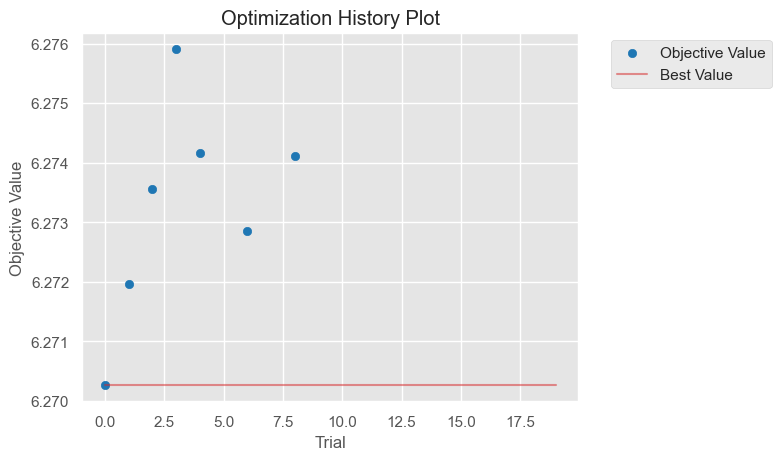

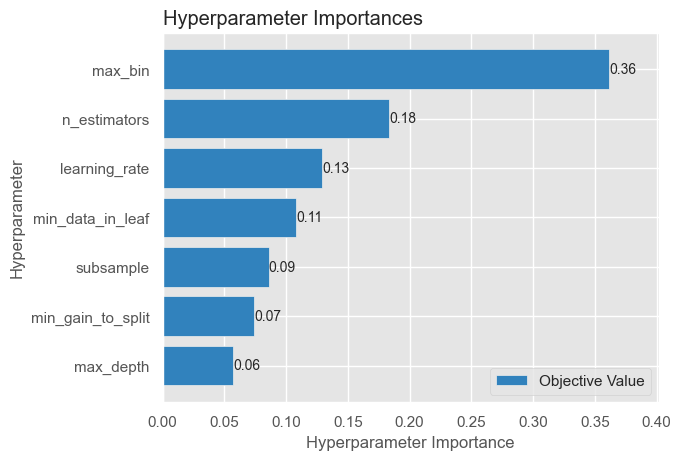

In [7]:
print(f"\tBest value (mse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")
plot_optimization_history(study)
plot_param_importances(study)

In [8]:
models = [
    ('LightGBM', LGBMRegressor(random_state=seed, objective='mse',
     device_type='gpu', early_stopping_rounds=100, **study.best_params))
]
model_save_path = "initial_run_tuning_2"
for (label, model) in models:
    _ = cross_validation(
        model,
        save_path=model_save_path,
        X=X,
        y=y,
        X_test=X_test,
        label=label
    )

[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] min_data_in_leaf is set=4100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4100
[LightGBM] [Warning] min_gain_to_split is set=10.128856386646307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.128856386646307
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3879
[LightGBM] [Info] Number of data points in the train set: 4714102, number of used features: 51
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel 

 Explore the model trained
 Job saved is a pipeline, the model is in second step

LGBMRegressor(device_type='gpu', early_stopping_rounds=100,
              learning_rate=0.06772311913826479, max_bin=78, max_depth=9,
              min_data_in_leaf=4100, min_gain_to_split=10.128856386646307,
              n_estimators=150, num_leaves=480, objective='mse',
              random_state=42, subsample=0.9138045192239712)


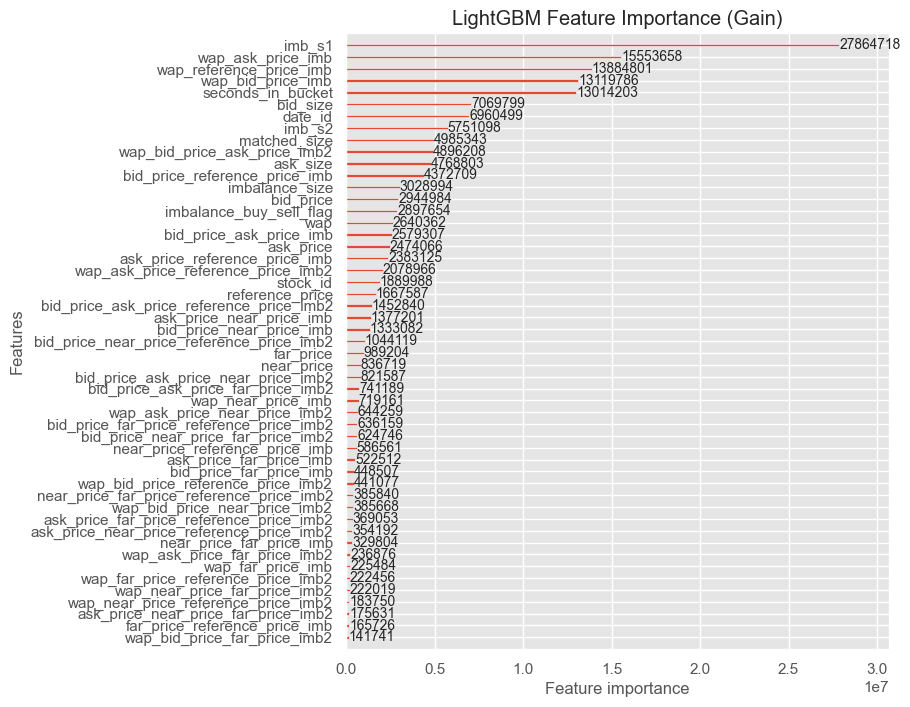

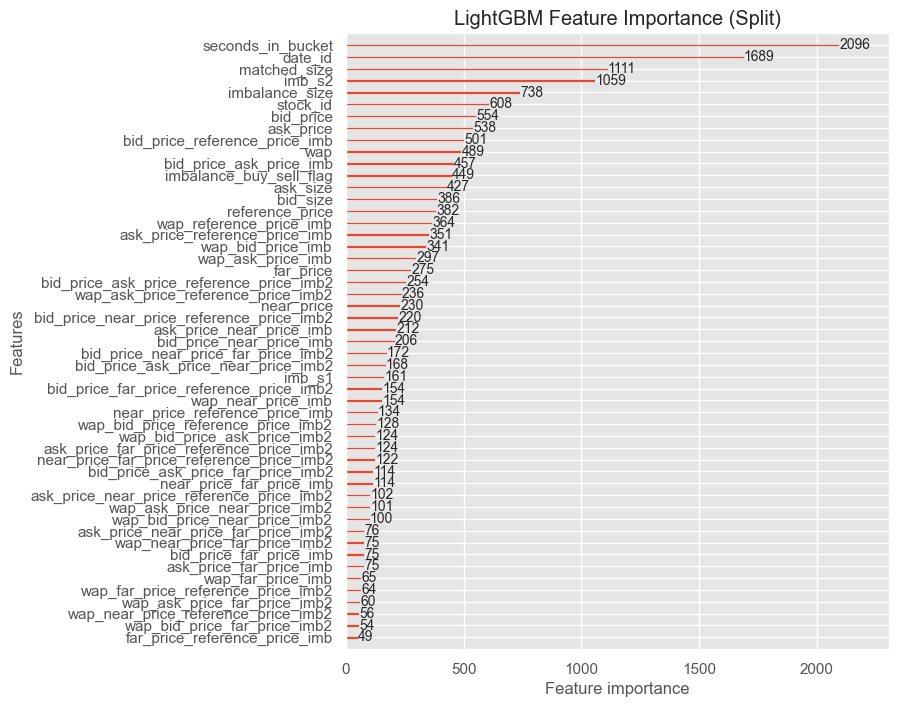

In [9]:
pipeline = joblib.load(f"./{model_save_path}/best_model.model")
trained_model = pipeline
print(trained_model)

lgb.plot_importance(trained_model, importance_type="gain", figsize=(
    7, 8), precision=0, title="LightGBM Feature Importance (Gain)")
plt.show()
lgb.plot_importance(trained_model, importance_type="split", figsize=(
    7, 8), precision=0, title="LightGBM Feature Importance (Split)")
plt.show()